In [1]:
# What version of Python do you have?
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
from datetime import datetime
import os
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix, plot_confusion_matrix
from PIL import Image
%matplotlib inline

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.6.0
Keras Version: 2.6.0

Python 3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]
Pandas 1.3.3
Scikit-Learn 0.24.2
GPU is available


In [2]:
os.getcwd()

'c:\\Users\\thoma\\Desktop\\speciale\\DeepLearning_Master\\models\\VGG16'

In [3]:
from tensorflow.python.keras import backend as K

K.clear_session()
tf.compat.v1.disable_eager_execution()

graph = None

def load_model():
    global loaded_model
    global graph

    loaded_model = tf.keras.models.load_model("efficiencynet__OnlySz.h5")
    graph = tf.compat.v1.get_default_graph()

load_model()

OSError: SavedModel file does not exist at: efficiencynet__OnlySz.h5\{saved_model.pbtxt|saved_model.pb}

In [37]:
# loaded_model = tf.keras.models.load_model("class_weigt_sgd.h5")

In [6]:
os.chdir("E:\Database")
train_path = "E:/Database/Multi_Channel_Chb01/windows/train"
test_path = "E:/Database/Multi_Channel_Chb01/windows/train"
os.getcwd()

'E:\\Database'

In [4]:
train_path = "../../../psd_dual_channel_10_patient/windows/train"

test_path = "../../../windows_01_only_sz/win_chb_01"

resnet152_input_shape = (224, 224)

inceptionV3_input_shape = (299, 299)

batch_size = 1

In [5]:
labels = [item for item in os.listdir(test_path)]
labels

['Interictal', 'Preictal_One', 'Preictal_Two', 'Seizure']

In [6]:
number_of_sz_class = len([item for item in os.listdir(test_path + '/' + 'Seizure')])

In [7]:
def limit_data_samples(data_dir, n=number_of_sz_class):
  a = []
  for i in os.listdir(data_dir):
    for index, item in enumerate(os.listdir(data_dir+'/'+i)):
      #if index > n:continue
      a.append((f'{data_dir}/{i}/{item}',i))
  return  pd.DataFrame(a, columns=['filename', 'class'])

In [8]:
test_df = limit_data_samples(test_path)

In [9]:
test_df['class'].value_counts()

Interictal      27232
Preictal_One    11856
Preictal_Two     7848
Seizure          1752
Name: class, dtype: int64

In [10]:
classes = test_df['class'].unique()

In [11]:
y = test_df['class']

In [12]:
from sklearn.utils import compute_class_weight
class_weights = compute_class_weight('balanced', classes, y)

C:\Users\thoma\anaconda3\envs\AI_keras_env_GPU\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=['Interictal' 'Preictal_One' 'Preictal_Two' 'Seizure'], y=0        Interictal
1        Interictal
2        Interictal
3        Interictal
4        Interictal
            ...    
48683       Seizure
48684       Seizure
48685       Seizure
48686       Seizure
48687       Seizure
Name: class, Length: 48688, dtype: object as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [14]:
class_weights = dict(enumerate(class_weights))

In [15]:
class_weights

{0: 0.4469741480611046,
 1: 1.0266531713900136,
 2: 1.5509683995922527,
 3: 6.947488584474886}

In [50]:
from tensorflow.keras.applications.efficientnet import preprocess_input
generator = ImageDataGenerator(
   preprocessing_function=preprocess_input
)

In [51]:
inc_test_gen = generator.flow_from_dataframe(test_df,batch_size=batch_size, target_size=inceptionV3_input_shape, shuffle=False)

Found 367 validated image filenames belonging to 4 classes.


In [52]:
res_test_gen = generator.flow_from_dataframe(test_df,batch_size=batch_size, target_size=resnet152_input_shape, shuffle=False)

Found 367 validated image filenames belonging to 4 classes.


In [53]:
def generator_test():
     while True:
        X1i = inc_test_gen.next()
        X2i = res_test_gen.next()
        yield [X1i[0], X2i[0]], X1i[1]

In [54]:
number_of_steps = inc_test_gen.samples // batch_size
number_of_steps

367

In [55]:
with graph.as_default():
    y_pred = loaded_model.predict(res_test_gen, steps=number_of_steps)

C:\Users\thoma\anaconda3\envs\AI_keras_env_GPU\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [56]:
y_pred_max = y_pred.argmax(axis=-1)

In [57]:
y_true = inc_test_gen.classes

In [58]:

from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix, plot_confusion_matrix

In [59]:
clf_report = classification_report(y_true=y_true, y_pred=y_pred_max, target_names=labels)

C:\Users\thoma\anaconda3\envs\AI_keras_env_GPU\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thoma\anaconda3\envs\AI_keras_env_GPU\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thoma\anaconda3\envs\AI_keras_env_GPU\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [60]:
print(clf_report)

              precision    recall  f1-score   support

  Interictal       0.00      0.00      0.00        92
Preictal_One       0.00      0.00      0.00        92
Preictal_Two       0.00      0.00      0.00        92
     Seizure       0.25      1.00      0.40        91

    accuracy                           0.25       367
   macro avg       0.06      0.25      0.10       367
weighted avg       0.06      0.25      0.10       367



In [61]:
confusion_matrix = confusion_matrix(y_true=y_true, y_pred=list(y_pred_max))

confusion_matrix

array([[ 0,  0,  0, 92],
       [ 0,  0,  0, 92],
       [ 0,  0,  0, 92],
       [ 0,  0,  0, 91]], dtype=int64)

In [62]:
import matplotlib

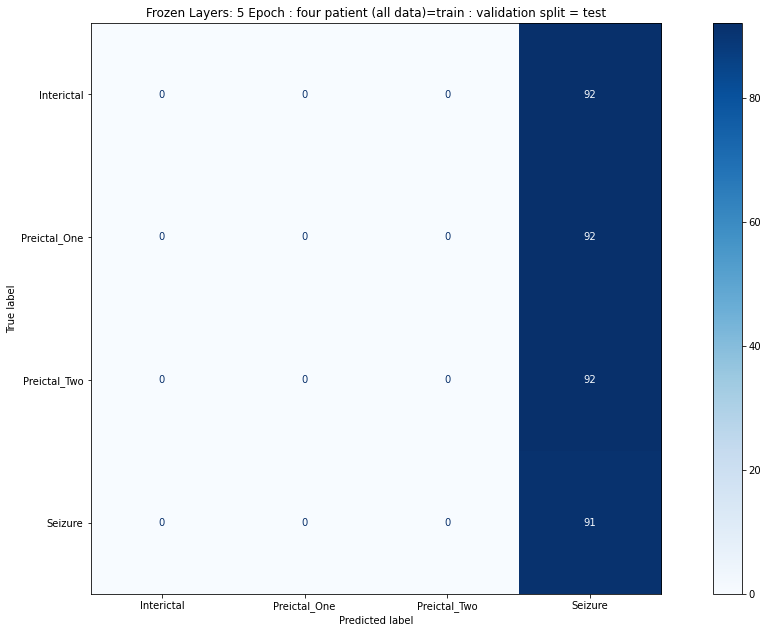

In [63]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels).plot(cmap='Blues')
plt.title("Frozen Layers: 5 Epoch : four patient (all data)=train : validation split = test")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig("resnet_only_sz_cb07_test.png")